# PG Stock Price Prediction RNN

This model was created by Neil G.

This file is licensed by the GNPU AGPLv3 License.

This repository seeks to create a successful RNN model to predict the PG Closing Stock Price using old closing price, high price, and low price data.

## Preparation

First, let's import the packages we need, certify the `tensorflow` version, and then read the csv file<sup>1</sup>. We will also do some mild inspection of the data.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2023-01-27 17:51:30.940263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.11.0'

In [4]:
df = pd.read_csv('pg.us.csv')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,0


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,12075.0,2.454466e+01,2.530346e+01,1.0247,2.484800e+00,10.835,4.446150e+01,9.347000e+01
High,12075.0,2.474157e+01,2.546747e+01,1.0327,2.500900e+00,10.939,4.480800e+01,9.396600e+01
Low,12075.0,2.435665e+01,2.514648e+01,1.0085,2.460700e+00,10.760,4.412900e+01,9.313200e+01
Close,12075.0,2.456085e+01,2.531467e+01,1.0085,2.484800e+00,10.859,4.447600e+01,9.369800e+01
Volume,12075.0,6.649886e+06,6.339737e+06,0.0000,2.425005e+06,5426144.000,9.026824e+06,1.701709e+08
OpenInt,12075.0,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000,0.000000e+00,0.000000e+00


So we have a fair amount of columns here that could be useful. We plan on predicting the `Close` category, which is the stock's closing price. We will use the high and low columns to aid with that. Before that, though, let's drop the `OpenInt` column, since it doesn't have any different data.

In [6]:
df = df.drop(columns=['OpenInt'])
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,12075.0,2.454466e+01,2.530346e+01,1.0247,2.484800e+00,10.835,4.446150e+01,9.347000e+01
High,12075.0,2.474157e+01,2.546747e+01,1.0327,2.500900e+00,10.939,4.480800e+01,9.396600e+01
Low,12075.0,2.435665e+01,2.514648e+01,1.0085,2.460700e+00,10.760,4.412900e+01,9.313200e+01
Close,12075.0,2.456085e+01,2.531467e+01,1.0085,2.484800e+00,10.859,4.447600e+01,9.369800e+01
Volume,12075.0,6.649886e+06,6.339737e+06,0.0000,2.425005e+06,5426144.000,9.026824e+06,1.701709e+08


In [7]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

It appears that the `Date` column contains `object` types (meaning strings). We would prefer to work wit hnumbers only, so we should convert the column into a column to dates since the starting date.

In [8]:
df['Date'] = df['Date'].astype('datetime64')
min_date = df['Date'].min()
max_date = df['Date'].max()

In [9]:
def delta(row): return row - min_date  # Calculate the amount of days between this and the first one

In [10]:
df['DateNumeric'] = df['Date'].apply(lambda x: delta(x))  # Apply changes to a new column titled DateNumeric
df.head()

,Date,Open,High,Low,Close,Volume,DateNumeric
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0 days
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,3 days
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,4 days
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,5 days
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,6 days


Now we can see that `DateNumeric` shows the amount of days from the starting date in 01/02/1970.

In [11]:
df.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
DateNumeric    timedelta64[ns]
dtype: object

Our `DateNumeric` is still not an `int` or `float`, so we can fix that real quick.

In [12]:
df['DateNumeric'] = df['DateNumeric'].astype('timedelta64[D]')
df.dtypes

Date           datetime64[ns]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume                  int64
DateNumeric           float64
dtype: object

In [13]:
df.head()

,Date,Open,High,Low,Close,Volume,DateNumeric
0,1970-01-02,1.3715,1.3796,1.3715,1.3796,1031284,0.0
1,1970-01-05,1.3796,1.3875,1.3715,1.3875,642565,3.0
2,1970-01-06,1.3796,1.3796,1.3715,1.3796,594971,4.0
3,1970-01-07,1.3796,1.4039,1.3796,1.4039,880559,5.0
4,1970-01-08,1.4039,1.4198,1.3956,1.4198,658435,6.0


Now our `Date` Numeric is just a `float` which is great! We can now drop the `Date` column.

In [14]:
date_df = df.copy()  # Copy the data frame with the date for graphing later
df = df.drop(columns=['Date'])
df.head()

,Open,High,Low,Close,Volume,DateNumeric
0,1.3715,1.3796,1.3715,1.3796,1031284,0.0
1,1.3796,1.3875,1.3715,1.3875,642565,3.0
2,1.3796,1.3796,1.3715,1.3796,594971,4.0
3,1.3796,1.4039,1.3796,1.4039,880559,5.0
4,1.4039,1.4198,1.3956,1.4198,658435,6.0


### Visualization

Let's graph the closing price history of all the data to get an insight to what we're working with. Then we'll check the shape of the data.

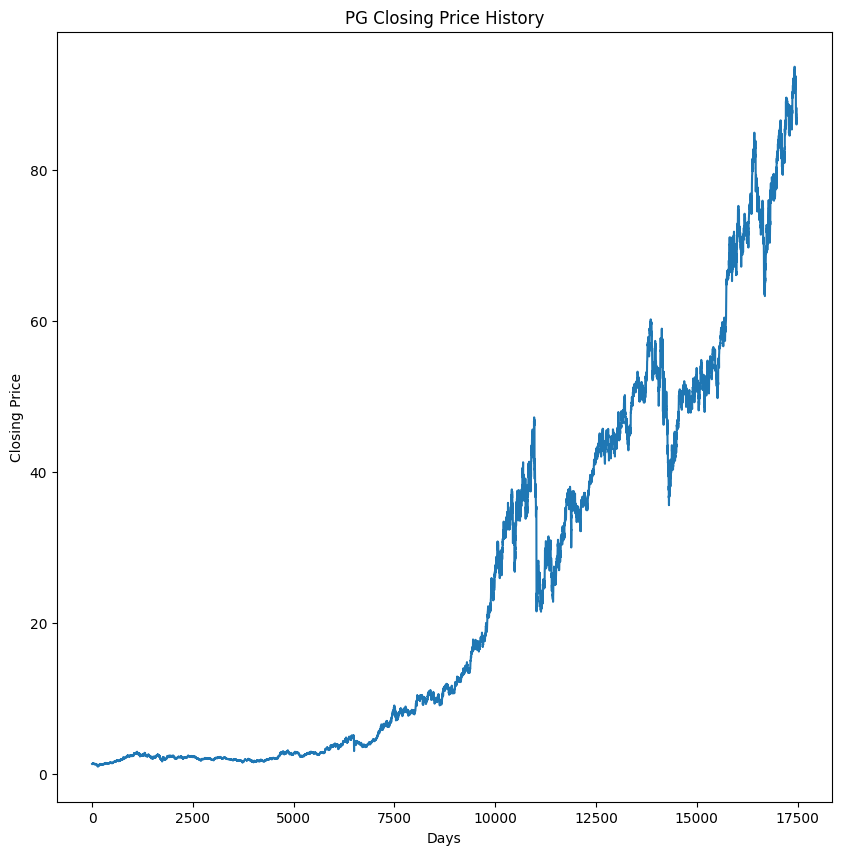

In [15]:
plt.figure(figsize=(10,10))
plt.plot(df["DateNumeric"], df["Close"])
plt.title('PG Closing Price History')
plt.ylabel('Closing Price')
plt.xlabel('Days')
plt.show()

In [16]:
df.shape

(12075, 6)

The shape `(12075, 6)` implies that we have six columns (which we do), and that we have 12,075 entries. This will be important for deciding where we will split the data for training and testing later.

Later, we will use `High` and `Low` price data, so let's see that on a graph.

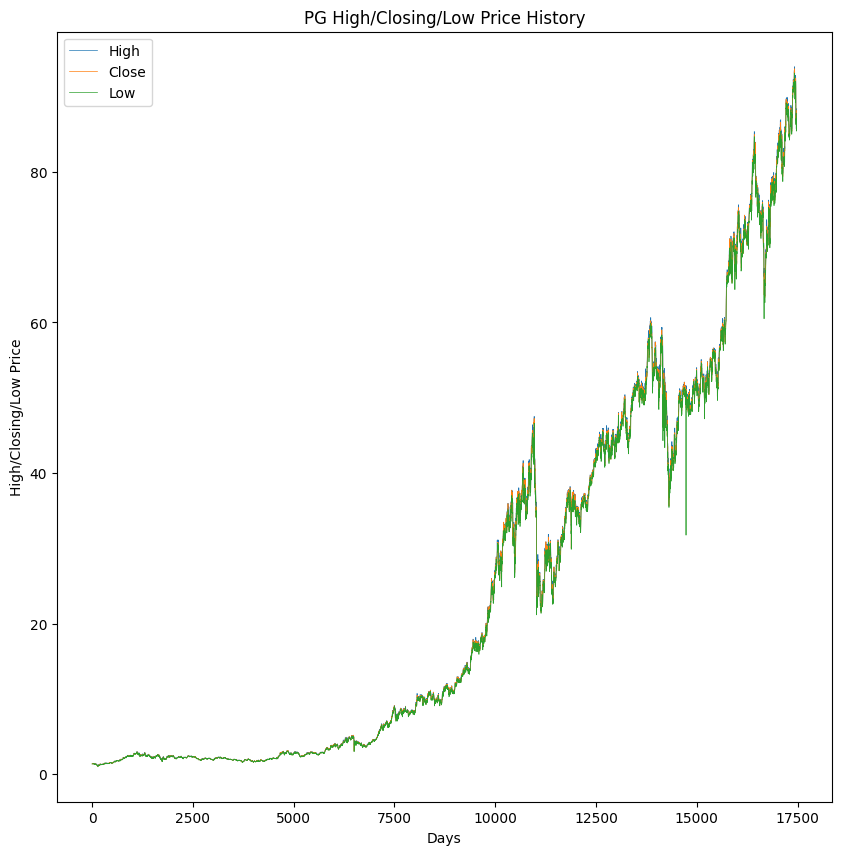

In [17]:
plt.figure(figsize=(10,10))
plt.plot(df["DateNumeric"], df["High"], label='High', linewidth=.5)
plt.plot(df["DateNumeric"], df["Close"], label='Close', linewidth=.5)
plt.plot(df["DateNumeric"], df["Low"], label='Low', linewidth=.5)
plt.title('PG High/Closing/Low Price History')
plt.ylabel('High/Closing/Low Price')
plt.xlabel('Days')
plt.legend(loc='best')
plt.show()

There isn't much variability, but the point around `14500` days will be an important one to look at.

### Reshaping

First let's isolate the closing price data and reshape it into a simple numpy array.

In [18]:
length = len(df)
Y = df.iloc[:,3]
Y = np.array(Y)
Y = Y.reshape(-1, 1)

Now we will use the `High` values and `Low` values, along with the `Close` price data to train our RNN. We will apply the above method for the other two columns, then concatenate all three into one array.

In [19]:
X1 = df.iloc[:,1]  # High value data
X1 = np.array(X1)
X1 = X1.reshape(-1, 1)
X2 = Y  # Close price data
X3 = df.iloc[:,2]  # Low value data
X3 = np.array(X3)
X3 = X3.reshape(-1, 1)
X = np.concatenate([X1, X2, X3], axis=1)  # Combine into one variable
print(f'{X.shape}\n{Y.shape}')

(12075, 3)
(12075, 1)


The shapes confirm that we have an array with three columns and an array with only one column. Now, let's scale the data into a more usable format, so the RNN is more resistant and rugged.

In [20]:
sc = MinMaxScaler()  # Scale based on min and max for all three prices
sc.fit(X)  # Fit the data
X = sc.transform(X)
sc2 = MinMaxScaler()  # Scale based on min and max for just closing price
sc2.fit(Y)  # Fit the data
Y = sc2.transform(Y)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # Reshape the X variable

Now let's split the data into training and testing sets. Neural networks tend to perform better with more data. We have about 12,000 entries, so let's attribute 11,800 to training, and the other 300 can be for testing.

In [21]:
X_train = X[:11800,:,:]
X_test = X[11800:,:,:]
Y_train = Y[:11800,:]
Y_test = Y[11800:,:]

### Modeling

Time for the model! We will use the `Sequential` model from tensorflow. Then we will add a LSTM layer to the RNN, with a hyperbolic tangent activation, and specify that our input shape will be three values. We then add a Dense layer. The summary of the model is then printed.

In [22]:
model = keras.Sequential()
model.add(tf.keras.layers.LSTM(10, activation='tanh', input_shape=(1, 3), recurrent_activation='hard_sigmoid'))
model.add(tf.keras.layers.Dense(1))
model.summary()

2023-01-27 17:51:37.501243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


Now we will compile the model with a loss metric of `mean_squared_error` and a metric for mean absolute error. We will fit the model to our training data, and let it iterate over 100 epochs. We will then make a prediction on the test data from earlier.

In [23]:
%%time
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[[tf.keras.metrics.mae]])
model.fit(X_train, Y_train, epochs=100, verbose=0)
prediction = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step
CPU times: user 1min 34s, sys: 10.3 s, total: 1min 45s
Wall time: 1min 7s


### Results

Let's graph the prediction and the actual closing values to see how our model did.

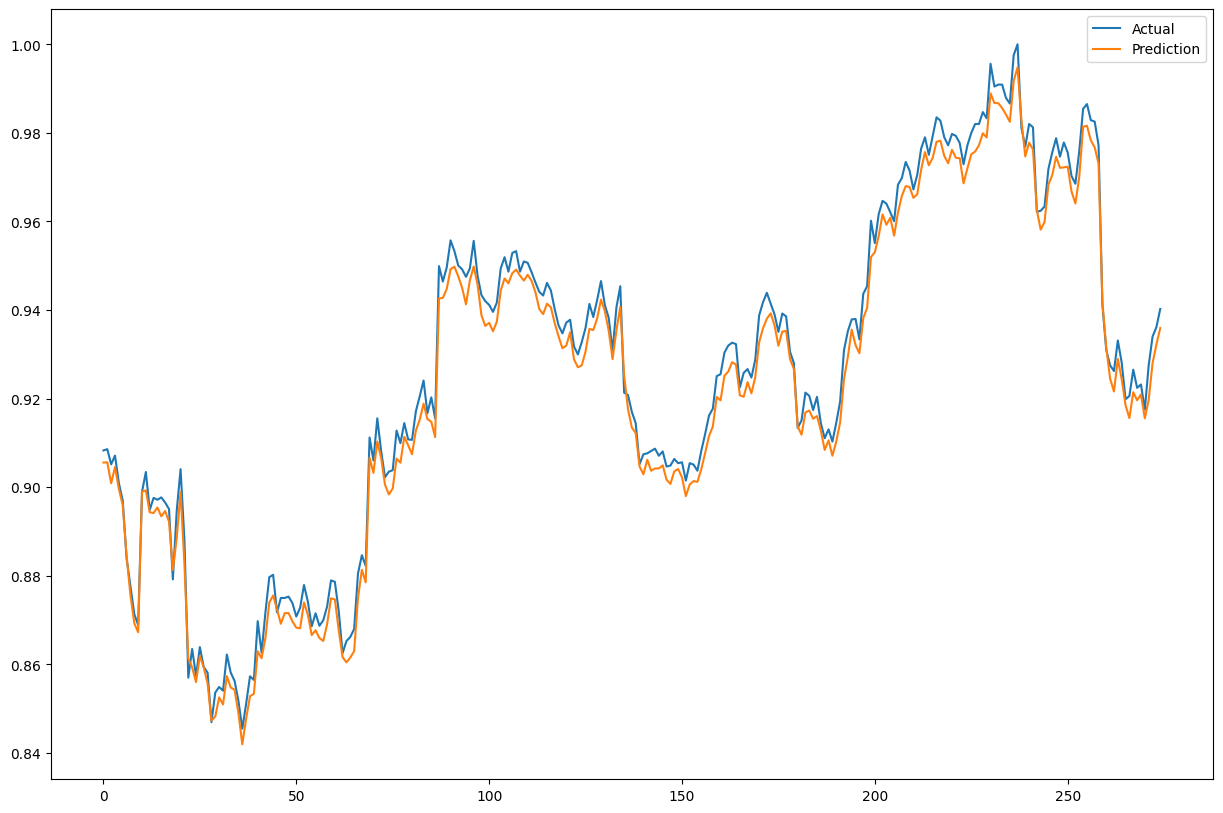

In [24]:
plt.figure(figsize=(15,10))
plt.plot(Y_test,label = 'Actual')
plt.plot(prediction, label = 'Prediction')
plt.legend(loc='best')
plt.show()

It seems that our model is doing really well! However, let's get a better scope of things by changing the x-axis to the date and the y-axis to a more adjusted price of the PG stock.

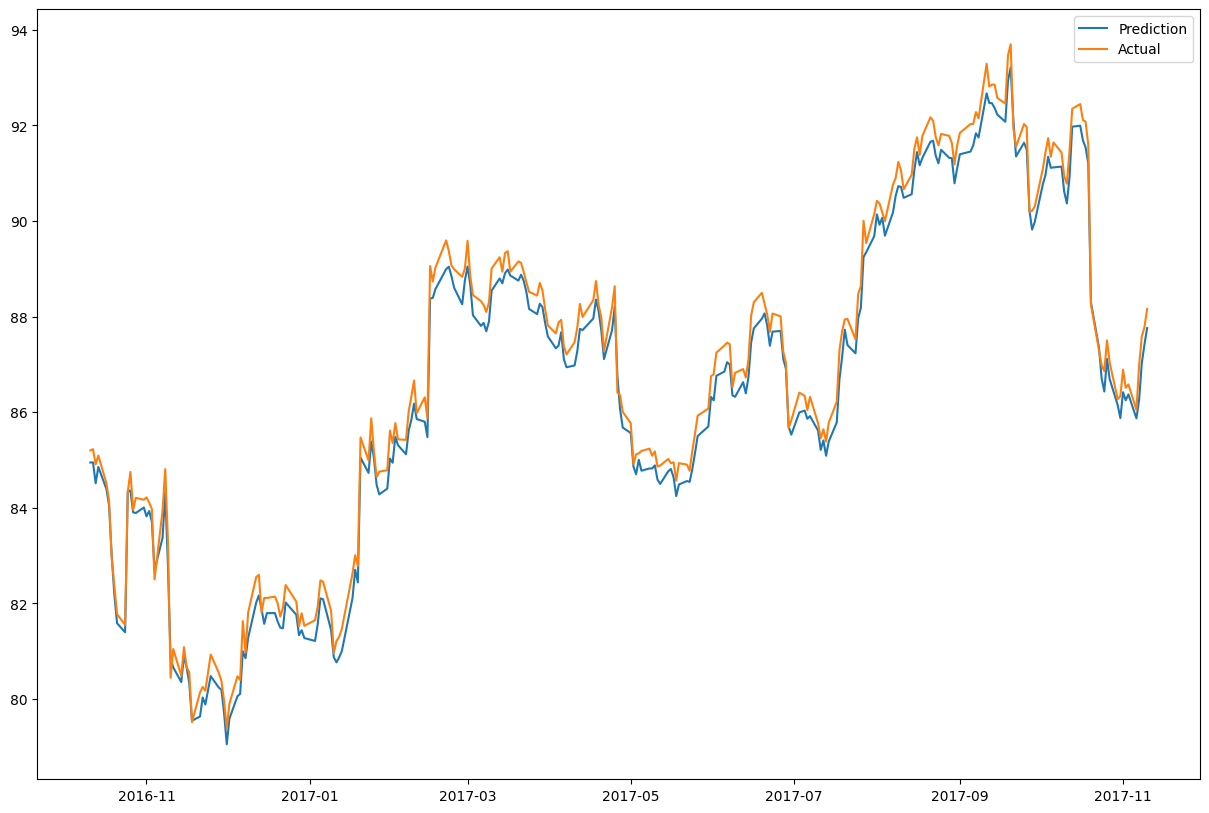

In [25]:
X2 = sc2.inverse_transform(prediction) # Undo scaling
Y2 = sc2.inverse_transform(Y_test) # Undo scaling
plt.figure(figsize=(15,10))
dates = np.expand_dims(date_df['Date'], axis=1)
plt.plot_date(dates[11800:], X2, '-', label = 'Prediction')
plt.plot(dates[11800:], Y2, '-', label = 'Actual')
plt.legend(loc='best')
plt.show()

Wit this we can see that there is not really that much variability. THe prediction model is pretty close to the actual data and does a good job of copying the shape the stock will take. It does, in general, seem to under-fit the actual closing price slightly. Let's zoom out and look at the bigger picture.

<Figure size 1000x1000 with 0 Axes>

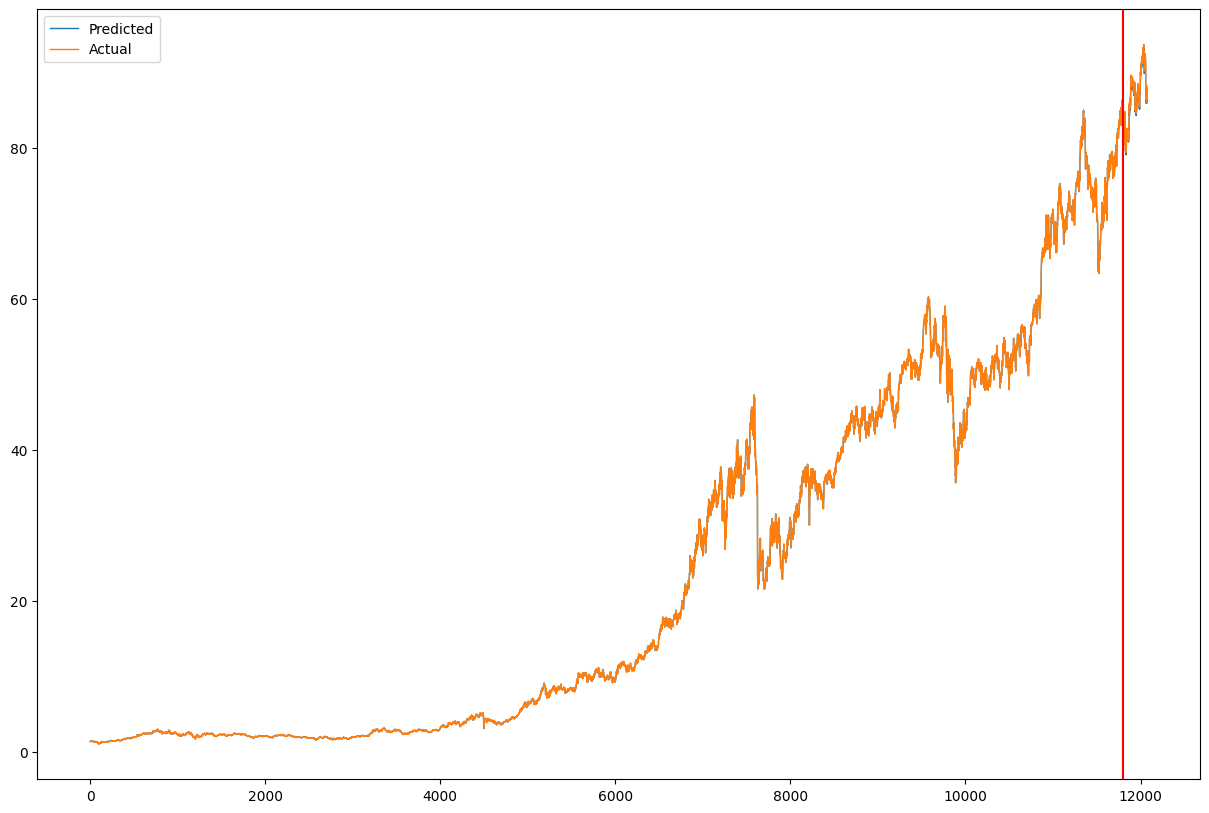

In [26]:
plt.figure(figsize=(10,10))
combined = np.append(Y_train, prediction)
combined = np.expand_dims(combined, axis=1)
combined = sc2.inverse_transform(combined)
plt.figure(figsize=(15,10))
plt.plot(combined,label = 'Predicted', linewidth=1)
plt.plot(df['Close'], label = 'Actual', linewidth=1)
plt.legend(loc='best')
plt.axvline(x = 11800, color = 'r', label = 'axvline - full height')
plt.show()

Once again, let's change the x-axis to the date. The y-axis has already been modified.

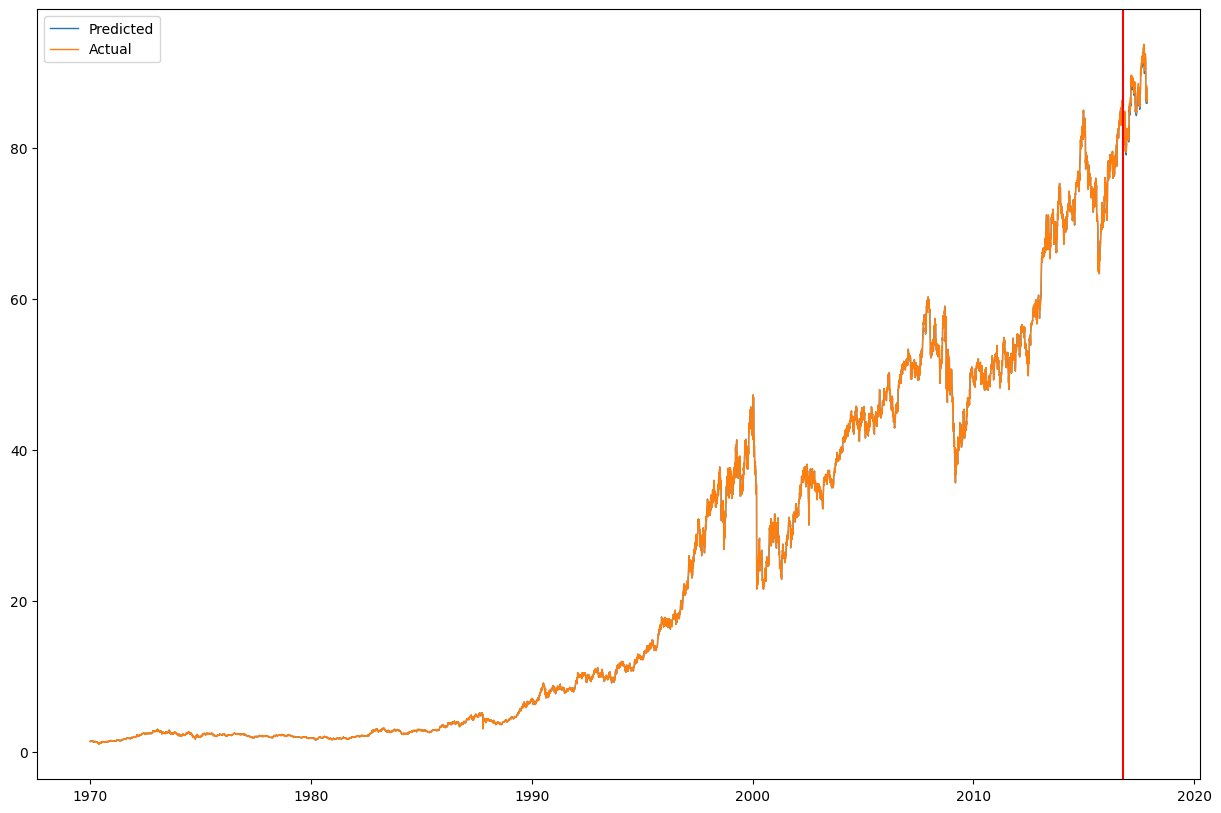

In [29]:
plt.figure(figsize=(15,10))
plt.plot_date(date_df['Date'], combined, '-', label='Predicted', linewidth=1)
plt.plot_date(date_df['Date'], df['Close'], '-', label='Actual', linewidth=1)
plt.legend(loc='best')
plt.axvline(x=df['DateNumeric'][11800], color='r')

In the grand scheme of things, it's hard to notice the variability. The vertical line represents the time when the prediction starts. When you zoom out, the prediction is pretty accurate. We can add the high and low stock values to see where our prediction lies. We will zoom into the prediction timeline once again to get a better look.

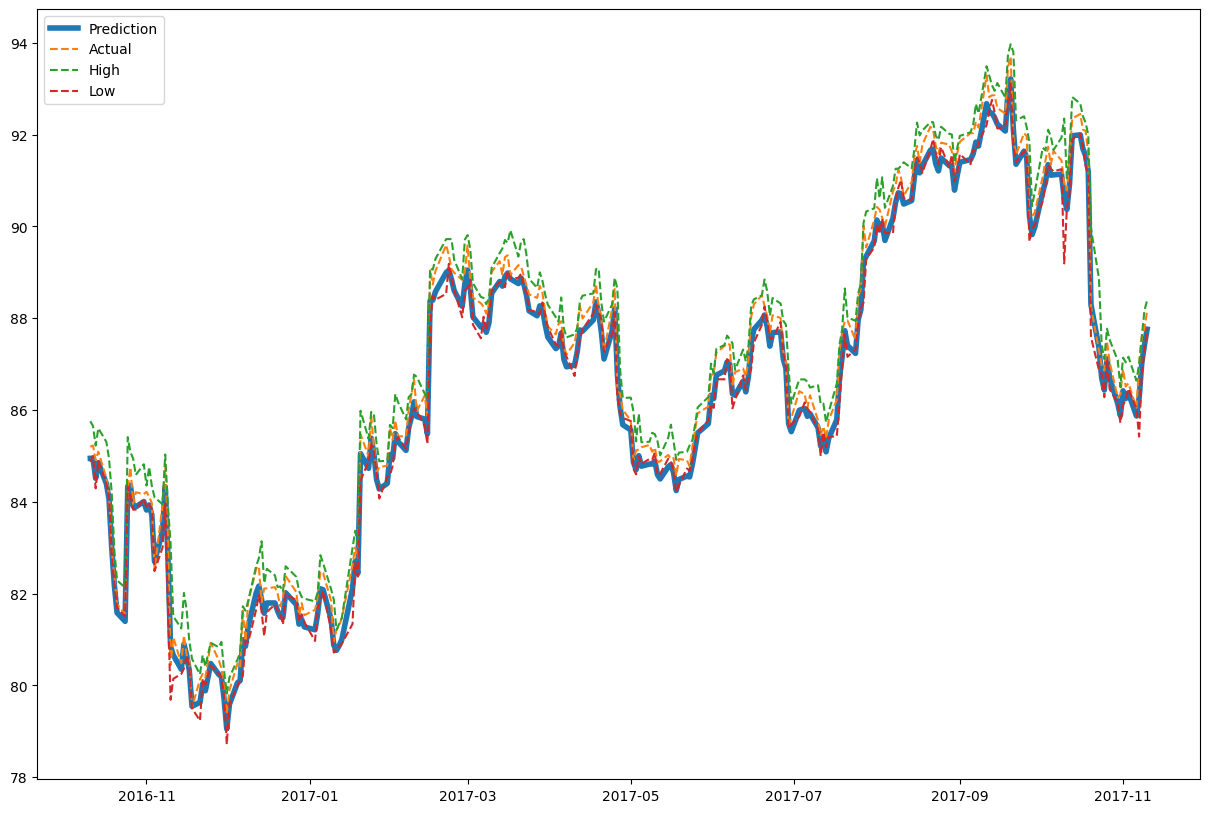

In [28]:
plt.figure(figsize=(15,10))
dates = np.expand_dims(date_df['Date'], axis=1)
plt.plot_date(dates[11800:], X2, '-', label = 'Prediction', linewidth=4)
plt.plot(dates[11800:], Y2, '--', label = 'Actual')
plt.plot(dates[11800:], df['High'][11800:], '--', label='High')
plt.plot(dates[11800:], df['Low'][11800:], '--', label='Low')
plt.legend(loc='best')
plt.show()

We can see that the model does pretty good as well at keeping the prediction between the high and low values of the stock during this time period. Remember, it did *not* have access to these values. In general, as stated prior, it seems to fall closer to the low end than the center (typically where the close lies). However, this is still great, and I am personally satisfied with this result.

### Acknowledgements

<sup>1</sup>[Kaggle Stock/ETF Data Set](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

<hr>

Packages Used:
* [TensorFlow](https://www.tensorflow.org)
* [SKLearn](https://scikit-learn.org/stable/)
* [Matplotlib](https://matplotlib.org)
* [Pandas](https://pandas.pydata.org)
* [NumPy](https://numpy.org)